# Autoencoder Entropy Experiment
`autoencoder-entropy.ipynb`

This notebook accompanies the subsection *Autoencoders and Nonlinear Compression*.

We will:

1. Train small fully connected autoencoders on MNIST for several bottleneck dimensions  
   \( d \in \{8,16,32,64\} \).
2. For each trained autoencoder, encode the MNIST test set into latent codes \( Z \).
3. Discretize the latent activations and estimate an empirical latent entropy \( H(Z) \).
4. Visualize:
   - A histogram of latent activations (for one bottleneck size) together with the
     estimated entropy;
   - The entropy \( H(Z) \) as a function of bottleneck size \( d \).

All figures are saved into the directory `figs/` as:
- `figs/ae_entropy_hist.png`
- `figs/ae_entropy_vs_dim.png`

In [1]:
# -------------------------------------------------------------
# Imports and basic setup
# -------------------------------------------------------------
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# Create figs directory if it does not exist
os.makedirs("figs", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# For reproducibility (to the extent possible)
torch.manual_seed(0)
np.random.seed(0)

Using device: cpu


## 1. MNIST dataset

We use MNIST as a simple high-dimensional dataset:

- Input images: \(28 \times 28\) grayscale, flattened to 784-dimensional vectors.
- Pixel values are scaled to the range \([0,1]\).

In [2]:
# -------------------------------------------------------------
# MNIST data loaders
# -------------------------------------------------------------
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),              # [0,1]
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

Train size: 60000, Test size: 10000


## 2. Autoencoder architecture

We use a simple fully connected autoencoder:

- Encoder: \( \mathbb{R}^{784} \to 256 \to d \)
- Decoder: \( \mathbb{R}^{d} \to 256 \to 784 \)

with ReLU nonlinearities and a sigmoid output to keep reconstructions in \([0,1]\).

In [3]:
# -------------------------------------------------------------
# Autoencoder model
# -------------------------------------------------------------
class Autoencoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Sigmoid(),          # outputs in [0,1]
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        x_hat = self.decoder(z)
        return x_hat.view(-1, 1, 28, 28)
    
    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat, z

## 3. Training helper

We define a training loop that:

- Minimizes mean squared error (MSE) between input and reconstruction.
- Trains for a small number of epochs (sufficient for a didactic experiment).

In [4]:
# -------------------------------------------------------------
# Training function
# -------------------------------------------------------------
def train_autoencoder(latent_dim: int, num_epochs: int = 5, lr: float = 1e-3):
    model = Autoencoder(latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for x, _ in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            x_hat, _ = model(x)
            loss = criterion(x_hat, x)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
        
        avg_loss = running_loss / len(train_loader.dataset)
        print(f"[latent_dim={latent_dim}] Epoch {epoch+1}/{num_epochs}, "
              f"Train MSE: {avg_loss:.4f}")
    
    return model

## 4. Training autoencoders for several bottleneck sizes

We train autoencoders for bottleneck dimensions:

\[
d \in \{8, 16, 32, 64\}.
\]

For each trained model we:

- Compute the reconstruction MSE on the test set;
- Collect the latent codes \(Z\) for the entire test set for entropy estimation.

In [5]:
# -------------------------------------------------------------
# Train models for several latent dimensions and collect latents
# -------------------------------------------------------------
latent_dims = [8, 16, 32, 64]
num_epochs = 5

models = {}
latents = {}
recon_mse = {}

criterion = nn.MSELoss()

for d in latent_dims:
    print("\n==============================")
    print(f"Training autoencoder with latent_dim = {d}")
    print("==============================")
    model = train_autoencoder(latent_dim=d, num_epochs=num_epochs, lr=1e-3)
    models[d] = model

    # Evaluate reconstruction error and collect latent codes on test set
    model.eval()
    all_z = []
    running_loss = 0.0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            x_hat, z = model(x)
            loss = criterion(x_hat, x)
            running_loss += loss.item() * x.size(0)
            all_z.append(z.cpu().numpy())
    
    test_mse = running_loss / len(test_loader.dataset)
    recon_mse[d] = test_mse
    latents[d] = np.concatenate(all_z, axis=0)
    print(f"[latent_dim={d}] Test MSE: {test_mse:.4f}")


Training autoencoder with latent_dim = 8
[latent_dim=8] Epoch 1/5, Train MSE: 0.0422
[latent_dim=8] Epoch 2/5, Train MSE: 0.0255
[latent_dim=8] Epoch 3/5, Train MSE: 0.0234
[latent_dim=8] Epoch 4/5, Train MSE: 0.0222
[latent_dim=8] Epoch 5/5, Train MSE: 0.0214
[latent_dim=8] Test MSE: 0.0209

Training autoencoder with latent_dim = 16
[latent_dim=16] Epoch 1/5, Train MSE: 0.0401
[latent_dim=16] Epoch 2/5, Train MSE: 0.0184
[latent_dim=16] Epoch 3/5, Train MSE: 0.0158
[latent_dim=16] Epoch 4/5, Train MSE: 0.0146
[latent_dim=16] Epoch 5/5, Train MSE: 0.0137
[latent_dim=16] Test MSE: 0.0130

Training autoencoder with latent_dim = 32
[latent_dim=32] Epoch 1/5, Train MSE: 0.0405
[latent_dim=32] Epoch 2/5, Train MSE: 0.0154
[latent_dim=32] Epoch 3/5, Train MSE: 0.0114
[latent_dim=32] Epoch 4/5, Train MSE: 0.0096
[latent_dim=32] Epoch 5/5, Train MSE: 0.0086
[latent_dim=32] Test MSE: 0.0080

Training autoencoder with latent_dim = 64
[latent_dim=64] Epoch 1/5, Train MSE: 0.0393
[latent_dim=64] 

## 5. Estimating latent entropy \(H(Z)\)

Given a collection of latent codes \(Z \in \mathbb{R}^{N \times d}\), we:

1. Flatten all coordinates into a single 1D array;
2. Build a histogram with a chosen number of bins;
3. Normalize the histogram to obtain a discrete distribution \(P_Z\);
4. Compute the empirical entropy

\[
   H(Z) \approx -\sum_{z} P_Z(z)\,\log_2 P_Z(z).
\]

In [6]:
# -------------------------------------------------------------
# Entropy estimation helper
# -------------------------------------------------------------
def estimate_entropy_from_latents(z_array: np.ndarray, num_bins: int = 50) -> float:
    # Estimate entropy (in bits) from latent codes z_array of shape (N, d)
    # using a 1-dimensional histogram over all coordinates.
    z_flat = z_array.reshape(-1)
    
    hist, _ = np.histogram(z_flat, bins=num_bins, density=False)
    total = hist.sum()
    if total == 0:
        return 0.0
    p = hist.astype(np.float64) / total
    p = p[p > 0.0]  # avoid log(0)
    H_bits = -np.sum(p * np.log2(p))
    return float(H_bits)

In [7]:
# -------------------------------------------------------------
# Compute latent entropies H(Z) for each latent dimension
# -------------------------------------------------------------
latent_entropy_bits = {}

for d in latent_dims:
    HZ = estimate_entropy_from_latents(latents[d], num_bins=50)
    latent_entropy_bits[d] = HZ
    print(f"Estimated H(Z) for latent_dim={d}: {HZ:.3f} bits")

Estimated H(Z) for latent_dim=8: 4.833 bits
Estimated H(Z) for latent_dim=16: 4.548 bits
Estimated H(Z) for latent_dim=32: 4.522 bits
Estimated H(Z) for latent_dim=64: 4.193 bits


## 6. Visualizing latent distributions and entropy

We first plot a histogram of latent activations for one chosen bottleneck
dimension (here \(d=16\)) and report the estimated entropy on the figure.

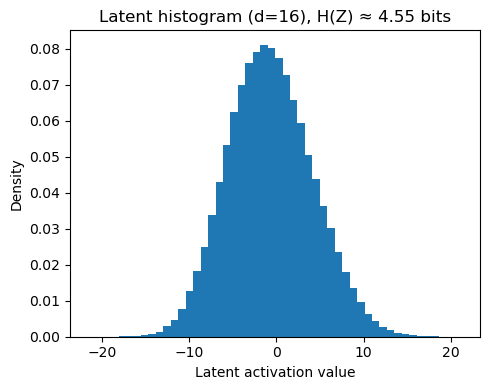

Saved latent histogram figure to figs/ae_entropy_hist.png


In [8]:
# -------------------------------------------------------------
# Histogram of latent activations for one bottleneck size
# -------------------------------------------------------------
latent_dim_plot = 16  # change if desired
z_plot = latents[latent_dim_plot].reshape(-1)

HZ_plot = latent_entropy_bits[latent_dim_plot]

plt.figure(figsize=(5, 4))
plt.hist(z_plot, bins=50, density=True)
plt.xlabel("Latent activation value")
plt.ylabel("Density")
plt.title(f"Latent histogram (d={latent_dim_plot}), H(Z) ≈ {HZ_plot:.2f} bits")
plt.tight_layout()
out_path = "figs/ae_entropy_hist.png"
plt.savefig(out_path, dpi=200)
plt.show()

print(f"Saved latent histogram figure to {out_path}")

Next, we plot the estimated latent entropy \(H(Z)\) as a function of bottleneck
dimension \(d\).  This illustrates how stronger compression (smaller \(d\)) tends
to reduce latent entropy, at the cost of higher reconstruction error.

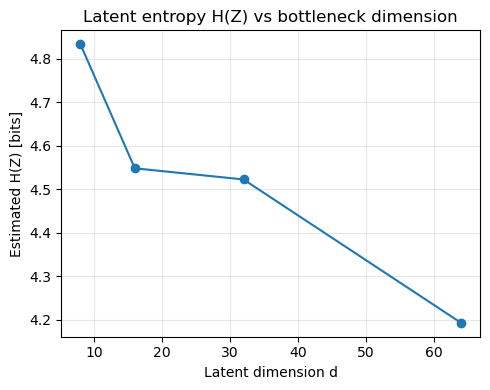

Saved entropy-vs-dim figure to figs/ae_entropy_vs_dim.png


In [9]:
# -------------------------------------------------------------
# Plot H(Z) vs latent_dim
# -------------------------------------------------------------
dims_sorted = sorted(latent_entropy_bits.keys())
H_values = [latent_entropy_bits[d] for d in dims_sorted]

plt.figure(figsize=(5, 4))
plt.plot(dims_sorted, H_values, marker="o")
plt.xlabel("Latent dimension d")
plt.ylabel("Estimated H(Z) [bits]")
plt.title("Latent entropy H(Z) vs bottleneck dimension")
plt.grid(alpha=0.3)
plt.tight_layout()
out_path = "figs/ae_entropy_vs_dim.png"
plt.savefig(out_path, dpi=200)
plt.show()

print(f"Saved entropy-vs-dim figure to {out_path}")

## 7. (Optional) Reconstruction error vs. bottleneck size

For completeness, we can also inspect how reconstruction MSE changes with
latent dimension.  This helps visualize the trade-off between compression
and reconstruction quality.

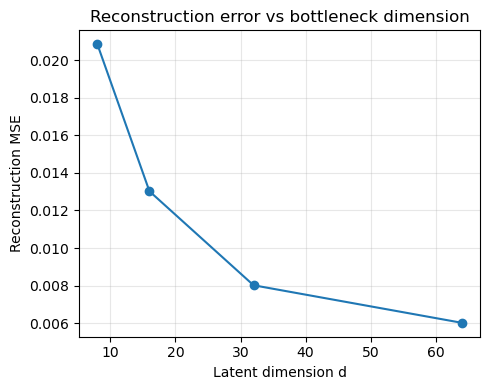

In [10]:
# -------------------------------------------------------------
# Optional: reconstruction MSE vs latent_dim
# -------------------------------------------------------------
dims_sorted = sorted(recon_mse.keys())
mse_values = [recon_mse[d] for d in dims_sorted]

plt.figure(figsize=(5, 4))
plt.plot(dims_sorted, mse_values, marker="o")
plt.xlabel("Latent dimension d")
plt.ylabel("Reconstruction MSE")
plt.title("Reconstruction error vs bottleneck dimension")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()